In [1]:
%load_ext autoreload
%autoreload 2

from model_utils import train_model, split_data, split_branches, get_model, set_pretrained_model_dropout, get_dataset, ModelSeeder
from config import Config
import json
import matplotlib.pyplot as plt
%matplotlib inline
import math
import random
import time
import onnx
import logging
from onnx_model_manager import OnnxModelManager
from onnxruntime.quantization import quantize_dynamic, QuantType
import os
import datasets
import torch
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM
from model_manager import ModelManager

In [2]:
# seed = random.randint(0, 2 ** 32 - 1)
seed = 3218885689
random.seed(seed)
datasets.logging.set_verbosity(datasets.logging.ERROR)
# Tell pytorch to run this model on the GPU.
device_name = "cuda:0" if torch.cuda.is_available() else "cpu"
# device_name = "cpu"
device = torch.device(device_name)
print(f"Will use {device_name} for training with seed: {seed}")

Will use cuda:0 for training with seed: 3218885689


In [3]:
split_data(os.path.join(Config.work_dir, "awsw_story_input.txt"))

In [4]:
config = {
    "lr": 6e-4,
    "warmup_factor": 0,
    "scheduler": "polynomial_decay_schedule_with_warmup",
    "lr_end": 2e-6,
    "power": 0.6,
    #"freeze_layer_rate": 1e-4,
    "freeze_from_steps": -1,
    "seed": seed,
    "num_epoch": 500
}

optuna_result_attachement = {
    'lr': 0.001,
    'scheduler': 'cosine_schedule_with_warmup',
    'to_freeze_count': 0,
    #"to_freeze_gpt_blocks": 11,
    'warmup_factor': 1
}
config.update(optuna_result_attachement)

In [5]:
saved_model_path = os.path.join("models", "awsw_main")
if os.path.exists(os.path.join(saved_model_path, "pytorch_model.bin")):
    tokenizer = AutoTokenizer.from_pretrained('EleutherAI/gpt-neo-125M')
    model = AutoModelForCausalLM.from_pretrained(saved_model_path)
    print("Pretrained model loaded")
else:
    model, tokenizer = get_model("EleutherAI/gpt-neo-125M")
    print("Loaded empty model")
model.to(device)
# set_pretrained_model_dropout(model.transformer.h[-1:], 0.05)

Loaded empty model


GPTNeoForCausalLM(
  (transformer): GPTNeoModel(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(2048, 768)
    (drop): Dropout(p=0, inplace=False)
    (h): ModuleList(
      (0): GPTNeoBlock(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPTNeoAttention(
          (attention): GPTNeoSelfAttention(
            (attn_dropout): Dropout(p=0, inplace=False)
            (resid_dropout): Dropout(p=0, inplace=False)
            (k_proj): Linear(in_features=768, out_features=768, bias=False)
            (v_proj): Linear(in_features=768, out_features=768, bias=False)
            (q_proj): Linear(in_features=768, out_features=768, bias=False)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPTNeoMLP(
          (c_fc): Linear(in_features=768, out_features=3072, bias=True)
          (c_proj): Linear(in_features=3072, o

# Test before training on a pretrained model!

In [6]:
model.eval()
model_manager = ModelManager(model=model, tokenizer=tokenizer, device=device)
def test_regular_sampler():
    print(model_manager.say_raw("In my dreams, I'm a dragon", 50, 0.7))
test_regular_sampler()

In my dreams, I'm a dragon, a fighter, a sorcerer, a sorcerer. I am not a dragon. I am not a warrior. I am not a dragon's sword. I am not a warrior's bow. I am not a dragon's sword. I am not a warrior's bow. I am not a dragon's sword.

In the first two years of the war, I was in the middle of a war. The first battle was against the dragons of the north, the dragons of the south. The dragons were being used by a group of people who were fighting in the north. They were being used


# Reviewing our dataset!

In [7]:
dataset = get_dataset(tokenizer, path_train = os.path.join(Config.work_dir, "data_train.txt"))
print("Dataset demo snapshot:")
for item in dataset['train']:
    print(tokenizer.decode(item['input_ids']))
    break

print("RP review!")
has_seen_rp = False
for item in dataset['train']:
    decoded = tokenizer.decode(item['input_ids'])
    if 'c "Fight ' in decoded: 
        print(decoded)
        has_seen_rp = True
        continue        
    if has_seen_rp:
        print(decoded)
        break
# Clean up
del has_seen_rp
# dataset['model_seeder'].stop_worker()
# del dataset

  0%|          | 0/2 [00:00<?, ?it/s]

Dataset demo snapshot:


Token indices sequence length is longer than the specified maximum sequence length for this model (2085 > 2048). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (3376 > 2048). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2083 > 2048). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2159 > 2048). Running this sequence through the model will result in indexing errors


<d><scn>black<msg>Br "Alright."<|endoftext|><d><scn>town4<msg>Ad "That's right!"<|endoftext|><d><scn>viewingspot<msg>m "As the portal had been repaired by the mysterious person I met, now was the perfect time for Reza to make his getaway, and I was the only one who knew."<|endoftext|><d><scn>cafe<msg>Ad "I apologize. Let me try that again."<|endoftext|><d><scn>remyapt<msg>Ry "Anyways, is there anything in
RP review!


Token indices sequence length is longer than the specified maximum sequence length for this model (2085 > 2048). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (3376 > 2048). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2159 > 2048). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2083 > 2048). Running this sequence through the model will result in indexing errors


."<|endoftext|><d><scn>black<msg>Lo "Really? That's amazing!"<|endoftext|><d><scn>emeraroom<msg>Em "With the same biased thinking being present in the applicants, it would have been hard to find anyone among them who was actually suited to the position of working in the archives."<|endoftext|><p><msg>c "Angel"<|endoftext|><p><msg>c "Fight Emera"<d><scn>emeraroom<msg>m "I didn't hesitate and kicked Emera right in the stomach"<|endoftext|><p><msg>c "It could
 be something that would make me uncomfortable, or something you'd like to see me do."<d><scn>o2<msg>Ad "Anything?"<|endoftext|><p><msg>c "Meet with Bryce"<d><scn>bare<msg>Br "Oh, [player_name], I wasn't expecting visitors."<|endoftext|><d><scn>black<msg>An "Just wonderful. Stolen goods always taste best. I can already picture the old farmer reduced to tears after he discovers one of his precious Mouflons is gone."<|endoftext|><d><scn>o2<msg>


# Training

Model is put in training mode and we begin training. The `train_results` will contain all data after training is completed.

In [8]:
train_results = {}
model.train()
train_model(model, tokenizer, dataset, config, train_results)

[0] set freeze_part_layers: True (freezing 0 out of 160 layers.)


Step,Training Loss
535,11.180900
1070,3.174200
1605,2.703300
2140,2.375200
2675,2.207900
3210,2.124500
3745,2.062200
4280,2.054400
4815,1.995400
5350,1.987400


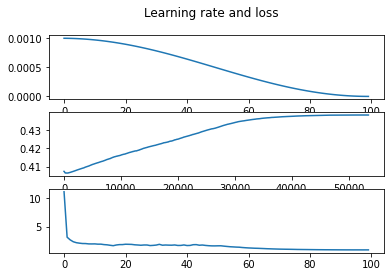

In [9]:
fig, axs = plt.subplots(3)
fig.suptitle('Learning rate and loss')
axs[0].plot(train_results['learning_rate_history'])
axs[1].plot(train_results['model_closeness_loss'])
axs[2].plot(train_results['loss_history'])

In [10]:
model.eval()
model.save_pretrained(saved_model_path)

# Conversion to ONNX
ONNX is a different format for running machine learning models. The ONNX format is much faster on CPU, sometimes 5 times as fast as PyTorch!

While the EAWSW model is designed to be small, accurate and accessible, for some people it's still too much to run...

Hosting the model as a free service for players is an option. An ONNX version of the model allows us to host the model on CPU yet have faster response times! Given that the model is made in a time with chip shortage, running on hardware I already have inside a server is efficient, scalable and cheaper.

An important note is that ONNX doesn't execute logic by itself, and you have to do that yourself, `onnx_model_manager.py` intends to deal with this for us.

In [11]:
saved_model_onnx_path = os.path.join("models", "awsw_onnx")
if not os.path.exists(os.path.join(saved_model_path, "special_tokens_map.json")):
    print("Copying config files from huggingface (needed for conversion)... WARNING: this assumes the structure of the model isn't changed!")
    !cd $saved_model_path && git clone https://huggingface.co/EleutherAI/gpt-neo-125M
    !cp -n $saved_model_path/gpt-neo-125M/* $saved_model_path
    !rm -rf $saved_model_path/gpt-neo-125M
if not os.path.exists(os.path.join(saved_model_onnx_path, "model.onnx")):
    !python3 -m transformers.onnx --model=$saved_model_path --feature=causal-lm-with-past $saved_model_onnx_path

Copying config files from huggingface (needed for conversion)... WARNING: this assumes the structure of the model isn't changed!
Cloning into 'gpt-neo-125M'...
remote: Enumerating objects: 38, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 38 (delta 16), reused 0 (delta 0)
Unpacking objects: 100% (38/38), 542.60 KiB | 999.00 KiB/s, done.
Using framework PyTorch: 1.10.0+cu113
Overriding 1 configuration item(s)
	- use_cache -> True
/usr/local/lib/python3.8/dist-packages/torch/onnx/utils.py:90: UserWarning: 'enable_onnx_checker' is deprecated and ignored. It will be removed in the next PyTorch release. To proceed despite ONNX checker failures, catch torch.onnx.ONNXCheckerError.
  warnings.warn("'enable_onnx_checker' is deprecated and ignored. It will be removed in "
/usr/local/lib/python3.8/dist-packages/torch/onnx/utils.py:103: UserWarning: `use_external_data_format' is deprecated and ignored. Will be removed in next PyT

In [12]:
def optimize_onnx():
    model_quant = os.path.join(saved_model_onnx_path, "model_quant.onnx")
    if not os.path.exists(model_quant):
        model_fp32 = os.path.join(saved_model_onnx_path, "model.onnx")
        model_opt = os.path.join(saved_model_onnx_path, "model-opt.onnx")
        quantized_model = quantize_dynamic(model_fp32, model_quant, weight_type=QuantType.QUInt8)
        #!rm $model_opt
optimize_onnx()

In [13]:
onnx_model_manager = OnnxModelManager(os.path.join(saved_model_onnx_path, "model.onnx"))

In [14]:
prompt = "In my dreams, I'm a dragon"
for i in range(10):
    print("ONNX:", onnx_model_manager.say_raw(prompt, do_sample=True))
    print("PyTorch:", model_manager.say_raw(prompt, 50, 0.7))
    print('-' * 100)

ONNX: In my dreams, I'm a dragon."<|endoftext|>
PyTorch: In my dreams, I'm a dragon."<d><scn>np2x<msg>Ad "I thought you had fun when we hung out in your apartment, but I guess I was wrong."<d><scn>np2x<msg>Ad "Wait, does this have something to do with what I've been hearing? About Reza being a murderer?"<|endoftext|>
----------------------------------------------------------------------------------------------------
ONNX: In my dreams, I'm a dragon one. I happen home calling home to do that could happen off them where't really more to be working overtime."<|endoftext|>
PyTorch: In my dreams, I'm a dragon one. can't down. You're a social g."<|endoftext|>
----------------------------------------------------------------------------------------------------
ONNX: In my dreams, I'm a dragon one. I didn't happen in conditions that could." you're. I don't already from with the wrong, so. { be."<|endoftext|>
PyTorch: In my dreams, I'm a dragon one. can tell me a little one right now."<|endoftex

# Testing

We created a few past (for context) + present prompts (player input) and see the different reactions. This way, we can test the models across different iterations.
The first test involves a old prompt to compare the pre-trained model with the one trained on AWSW. Did it manage to store it's data well? Is it able to write down things that have nothing to do with AWSW? (So we know we didn't overfit).

In [15]:
test_regular_sampler()

In my dreams, I'm a dragon."<|endoftext|>


**This test generates boring and repetetive** replies! It's because we use no good sampling algorithm, but it does give us a indication of what the model has learned!

In [16]:
prompts = [
    ('<p><msg>c "Hey Remy!"<d><scn>park2<msg>Ry "Hey!"', "How are you?"),
    ('<p><msg>c "I was with Lorem today."<d><scn>park2<msg>Ad "Very nice."', "What do you think of Lorem?"),
    ('<p><msg>m "In Tatsu park, Adine and I sat down."', "Oh my god, Adine. What is this?"),
    ('<p><msg>m "I sat down on a chair in Anna\'s lab."', "What will we do here?"),
]

def sample_test(model_manager):
    for (past, prompt) in prompts:
        reply = model_manager.say(past, prompt)
        print(f"Prompt: {prompt}\nReply: {reply}\n\n")
print("Test Pytorch...")
start = time.time()
sample_test(model_manager)
end = time.time()
pytorch_time = end - start
print("Test ONNX...")
start = time.time()
sample_test(onnx_model_manager)
end = time.time()
onnx_time = end - start
print(f"PyTorch on {device} took {pytorch_time:.4f} seconds")
print(f"ONNX on CPU took {onnx_time:.4f} seconds")

Test Pytorch...
Prompt: How are you?
Reply: park2<msg>Ry "I enjoy Tatsu Park is all. Have you been here before?"<p><msg>c "It was entertaining. We take to take a lot a lot."<d><scn>park2<msg>Ry "I'm not sure about that."<p><msg>c "I'm not sure what to that."<d><scn>park2<msg


Prompt: What do you think of Lorem?
Reply: o2<msg>Ad "I should be going now."<p><msg>c "I'm not surprised, I am not a linguist. Are you?"<d><scn>o2<msg>Ad "I'm not sure exactly, but they do say it was humans that made us who we are today. You don't seem so different from us


Prompt: Oh my god, Adine. What is this?
Reply: black<msg>Lo "Don't worry, though. I'll treat this delicate matter with the required finesse."<p><msg>c "I'm not sure, I am not a linguist. Are you?"<d><scn>black<msg>Br "Go ahead."<p><msg>c "I'm not sure, I am not a linguist. Are you?"<d


Prompt: What will we do here?
Reply: black<msg>An "We can just leave it here. Hey, maybe the old farmer will help himself to it."<p><msg>c "I'm not sure if i

# Sampling test

This is gonna be interesting!

In [17]:
print("Test Pytorch...")
start = time.time()
for i in range(1):
    for (past, prompt) in prompts:
        reply = model_manager.say(past, prompt, top_k = 50, top_p = 0.7)
        print(f"[Test {i + 1}] -> Prompt: {prompt}\nReply: {reply}\n")
    print("-------------")
end = time.time()
pytorch_time = end - start
print("Test ONNX...")
logging.basicConfig(level=logging.DEBUG)
start = time.time()
for i in range(1):
    for (past, prompt) in prompts:
        reply = onnx_model_manager.say(past, prompt, do_sample = True)
        print(f"[Test {i + 1}] -> Prompt: {prompt}\nReply: {reply}\n")
    print("-------------")
end = time.time()
onnx_time = end - start
print(f"PyTorch on {device} took {pytorch_time:.4f} seconds")
print(f"ONNX on CPU took {onnx_time:.4f} seconds")

Test Pytorch...
[Test 1] -> Prompt: How are you?
Reply: park2<msg>Ry "I don't know. I'm here as a courtesy to you, not to threaten or intimidate. Do with that information whatever you wish."<d><scn>facin2<msg>Ry "This attitude of yours is not helpful."<d><scn>facin2<msg>An "Whatever."<d><scn>facin2<msg>n

[Test 1] -> Prompt: What do you think of Lorem?
Reply: park2<msg>Ry "It's a long story."<p><msg>c "No."<|endoftext|>

[Test 1] -> Prompt: Oh my god, Adine. What is this?
Reply: cafe<msg>An "I'm not sure I'd go so far as to call it "fascinating", but it surely does give me a lot of opportunities."<|endoftext|>

[Test 1] -> Prompt: What will we do here?
Reply: black<msg>An "I'm not sure how you could ever survive in the wild."<d><scn>black<msg>An "Seriously, what god did you piss off to end up like that?"<p><msg>c "No, I'm already here and have nothing else to do, so let's make the most of this."<d><scn>black<msg>An "See how nice I am

-------------
Test ONNX...
[Test 1] -> Prompt: How 

# RP test
Testing out the injected roleplay actions

In [18]:
test_rps = [
    "Visit Lorem",
    "Meet with Lorem",
    "Visit Adine",
    "Fight Maverick",
    "Fight Adine",
    "Attack Adine"
]
for rp in test_rps:
    print(f'{rp} -> {model_manager.say("", rp, top_k = 50, top_p = 0.7)}')

Visit Lorem -> bare<msg>Lo "Oh, [player_name], I didn't expect you to arrive so early."<|endoftext|>
Meet with Lorem -> park2<msg>Kv "Hey [player_name]!"<|endoftext|>
Visit Adine -> park3<msg>Kv "Oh, [player_name], I wasn't expecting visitors."<|endoftext|>
Fight Maverick -> o2<msg>Ad "I know what you mean."<|endoftext|>
Fight Adine -> cafe<msg>An "Who is cited as one of our most important historians, his work spanning over 20 books, credited with mapping out our entire history since the beginning of sentience?"<p><msg>c "Damion Dandelionandelion"<|endoftext|>
Attack Adine -> emeraroom<msg>Em "Anyway, I have to keep reminding myself and practice, and problems behind the wholeness waiting to get it. Just, I think I'd like that I made a big only, and being."<d><scn>emeraroom<msg>Em "My parents wanted me to continue my studies, but I decided against that. Studying and working hard so that I may study and working for a friend where it wasn't long."<|endoftext|>
